<center><font size="6">Хакатон от Моторики</font>

[Второй этап](https://www.kaggle.com/competitions/motorica-continuous-command-classification/)

Команда 1.

# Условие задачи, загрузка и описание данных 

Задача: 
Построить классификационную модель, которая по показаниям от датчиков будет определять жест, выполненный пользователем протеза кисти во время записи данных, что отражено в значении целевой переменной.

В исходном файле *y_train* отражен только момент подачи сигнала. В задаче необходимо по показаниям датчиков предсказать жест (класс) и момент совершения жеста, который совершается позже момента подачи сигнала. Если подать на обучение *X_train* и *y_train* без дополнительного преобразования, то даже если модель обучится очень хорошо (f1-score ~ 1), результат предсказания на тестовой выборке (*X_test*) в Public Leaderboard будет очень плохим (было получено значение 0.77481). Таким образом, для достижения удовлетворительной точности определения моделью момента выполнения жеста по показаниям датчиков необходимо лучше понять данные, с которыми мы работаем. Далее будет кратко описан проведенный разведочный анализ.


Файлы:
* X_train.npy - обучающая выборка, имеющая размерности "наблюдения, датчики, время"
* X_test.npy - тестоваая выборка, имеющая размерности "наблюдения, датчики, время"
* y_train.npy - маска выполнения жеста для обучающей выборки, которая имеет размерность  (наблюдения * время) и содержит следующие классы:

| Номер <br> класса | Описание жеста |
| :---: | :--- |
| "0"  |  жест "open" <br> *обозначает возвращение руки в состояние "раскрытая ладонь"* |
| "1"  |  сгиб мизинца |
| "2"  |  сгиб безымянного пальца |
| "3"  |  сгиб среднего пальца |
| "4"  |  сгиб жеста "пистолет" |
| "5"  |  сгиб указательного пальца |
| "6"  |  сгиб большого пальца |
| "7"  |  жест "ok" |
| "8"  |  жест "grab" <br> *означает схват* |

Временной промежуток составляет от 0 до 99 единиц.

# Import библиотек и описание функций

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# библиотеки машинного обучения
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import backend as K
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# отображать по умолчанию длину Датафрейма
pd.set_option("display.max_rows", 15, "display.max_columns", 9)  #9

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import os

### Подготовка данных

In [2]:
# загрузка файлов 
PATH = 'E:\Kaggle\Motorica_2'
# проверяем все ли правильно
print(os.listdir(PATH))

['.git', '1_Motorica_sprint2.ipynb', '2_1_Log model.ipynb', '3_0_NN_lstm.ipynb', 'figures', 'Motorica_2.py', 'README.md', 'sample_submission.csv', 'X_test.npy', 'X_train.npy', 'y_train.csv', '__init__.py', '__pycache__']


In [3]:
# библиотека вызова функций
import Motorica_2 as m

In [4]:
m.privet('Sasha')

privet Sasha


In [5]:
#загрузка обучающей выборки и меток классов
X_train = np.load(os.path.join(PATH, 'X_train.npy'))
y_train = pd.read_csv(os.path.join(PATH, 'y_train.csv'), sep='[-,]',  engine='python') 

#загрузка тестовой выборки
X_test = np.load(os.path.join(PATH, 'X_test.npy'))

print(f"Размерность файла 'X_train': {X_train.shape}. Размерность: наблюдения, датчики, время")
print(f"Размерность файла 'y_train': {y_train.shape}. Размерность: наблюдения, время")

Размерность файла 'X_train': (323, 40, 100). Размерность: наблюдения, датчики, время
Размерность файла 'y_train': (32300, 3). Размерность: наблюдения, время


Пропущенные значения в файле у_train отсутствуют. В графе "timestep" указано, что измерения проходили за 100 временных единиц. Перегруппируем данные в таблицу так, чтобы графами были временные промежутки, а значениями были индексы класса. Значения в графах представляют собой некоторый вектор класса в соответствующий момент времени.

In [6]:
"""y_train_vectors1 = y_train.pivot_table(index='sample', columns='timestep', values='class')
display(y_train_vectors1.head(3))
display(y_train_vectors1.shape)"""

"y_train_vectors1 = y_train.pivot_table(index='sample', columns='timestep', values='class')\ndisplay(y_train_vectors1.head(3))\ndisplay(y_train_vectors1.shape)"

In [7]:
# Группировка по классу
y_train.groupby(by='class', as_index=False).nunique() #

,class,sample,timestep
0,0,323,100
1,1,36,100
2,2,36,100
3,3,36,100
4,4,35,100
5,5,36,100
6,6,36,100
7,7,36,100
8,8,36,100


Для удобства адресации к массиву представим его в трехмерном виде.

In [8]:
y_train_vectors = y_train.pivot_table(index='sample', columns='timestep', values='class')

y_train_vectors = y_train_vectors.values
display(y_train_vectors)
print(f"Размерность: {y_train_vectors.shape}")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

Размерность: (323, 100)


Добавим возможность вывести индексы наблюдений.

In [9]:
y_train_gest = pd.read_csv(os.path.join(PATH, 'y_train.csv'), sep='[-]',  engine='python')
display(y_train_gest.head(2))
y_train_gest.shape

,sample,"timestep,class"
0,0,"0,0"
1,0,"1,0"


(32300, 2)

In [10]:
samples = m.get_test_id('0-1')

Наблюдения жеста 0-1: [10, 28, 46, 64, 82, 100, 118, 136, 154, 172, 190, 208, 226, 244, 262, 280, 298, 316]


In [11]:
def get_sensors_in_all_tests_plot(arg1, arg2):
  """
  Функция вывода диаграммы показания отдельных датчиков во всех наблюдениях конкретного жеста
  Аргументом функции является строка - список датчиков
  """
  #функция отбора наблюдений в переменную 'samples' 
  
  get_test_id(arg1)
  sensor_list = arg2 
  
  df_selected = pd.DataFrame(columns=range(100))
  for sample in samples:
      for sensor in sensor_list:
          #df = pd.Series([X_train[test,sensor]], index=[str(f"{sensor}")], name=str(f"{test}"))
          df = pd.DataFrame(X_train[sample,sensor]).T #, columns=range(100)
          #display(df)
          df_selected = pd.merge(df_selected, df, how='outer') # , how='outer'
  # определим сколько графиков выводить
  len(arg2)
  if len(arg2)%2==0:

    fig = make_subplots(rows=2, cols=2, subplot_titles=(
          f"датчик {arg2[0]}", f"датчик {arg2[1]}", 
          f"датчик {arg2[2]} ", f"датчик {arg2[3]}")
    )

    df_1 = df_selected.iloc[0::len(sensor_list)].T
    df_2 = df_selected.iloc[1::len(sensor_list)].T
    df_3 = df_selected.iloc[2::len(sensor_list)].T
    df_4 = df_selected.iloc[3::len(sensor_list)].T

    for i in df_1.columns: 
        fig.add_trace(go.Scatter(x=df_1.index, y=df_1[i]), row=1, col=1)

    for i in df_2.columns:
        fig.add_trace(go.Scatter(x=df_2.index, y=df_2[i]), row=1, col=2)

    for i in df_3.columns:
        fig.add_trace(go.Scatter(x=df_3.index, y=df_3[i]), row=2, col=1)
        
    for i in df_4.columns:
        fig.add_trace(go.Scatter(x=df_4.index, y=df_4[i]), row=2, col=2)
        


    fig.update_layout(height=800, width=1000, #yaxis_type='log', 
                      title_text="Показания датчиков " + str(sensor_list) + " в наблюдениях жеста 0-1", title_xanchor='left', title_font=dict(size = 22),
                      xaxis_title_text  = 'Время', yaxis_title_text  = 'Сигнал датчика', yaxis_range =[0 ,3500], 
                      xaxis2_title_text = 'Время', yaxis2_title_text = 'Сигнал датчика', yaxis2_range=[0 ,3500], 
                      xaxis3_title_text = 'Время', yaxis3_title_text = 'Сигнал датчика', yaxis3_range=[0 ,3000], 
                      xaxis4_title_text = 'Время', yaxis4_title_text = 'Сигнал датчика', yaxis4_range=[0 ,3000], 
                      showlegend=False # легенда загромождает картинку
    )
    fig.update_layout(title=dict(text=f'Рис. {plot_counter}'+' - Сигнал датчиков во всех наблюдениях жеста' + str(arg1), x=0.5, y=0.01, xanchor='center')
    )
    fig.show()
  

#get_sensors_in_all_tests_plot(['0-1'], [24, 27, 33, 36])

# Результаты

Проанализируем произвольно взятый жест 0-1 и отобразим показания датчиков.


<img src = "https://drive.google.com/uc?id=1N5Hlprzy1fT9RWHnztemL5qCrSMyg4yd" width=600, height=400> 

На рис.1 изображена диаграмма сигналов датчиков. Отметим, что датчики можно разделить по средней величине сигнала на 2 группы:
* активные (0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38). Их средняя величина превышает 200;
* спящие (все остальные), средняя величина менее 200.

Сравним диаграмму сигналов с тестовой выборкой.

<left><img src = "https://drive.google.com/uc?id=1T_1WLocUEHo5vpxxPGVmiP-FwMbzCgHr" width=500, height=200>  </left>

На рис.2 изображена диаграмма изменения класса сигнала. В районе 50 временного промежутка видно изменение класса жеста. Сравнивая её с диаграммой сигналов датчиков (рис.1) мы видим, что на первой реакция датчиков происходит с запаздыванием (примерно на 70 временном интервале).

Отфильтруем активные и пассивные датчики.

<img src = "https://drive.google.com/uc?id=1JTmtr2G6MlPWgZ4rMFWLZ4XkZVENWjQA" width=1000, height=400>


На Рис.3 слева представлены показания активных датчиков наблюдения 10, а справа - пассивных датчиков. Рассматривая динамику показаний активных датчиков во времени условно отметим 3 периода:

* 0 - 59 с. - "покой" и слабое изменение;
* 60 - 79 с. - "значительное изменение уровня" сигнала при выполнении жесте;
* 80 - 99 с. - "стабилизаця" после движения. 

Показания пассивных датчиков колеблются с низкой амплитудой по сравнению с амплитудой колебания активных датчиков. Изучим амплитуды сигналов.

<img src = "https://drive.google.com/uc?id=1r9VHMHNjMQHrPpHSQT-f1CU8lulvtI6n" width=500, height=300>

Распределение ампитуд по группам представлено на рис.4. Анализируя гистограмму можно сгруппировать датчики по величине амплитуды на 2 группы: 

| Абсолютная <br> амплитуда | группа датчиков |
| :--: | :-- |
| < 200 | слабые |
| > 200 | сильные |

Рассмотрим сигналы групп датчиков отдельно.

<img src = "https://drive.google.com/uc?id=1ZItr_hePY1nRq6hBAPnqoOdQ-O3A6kD5" width=1000, height=400> 

На рис. 5 слева сигналы "сильных" датчиков, справа - "слабых". Отметим характерный скачок амплитуды у сильных датчиков в районе 70 временного интервала и практически плавное изменение амплитуды у слабых датчиков. Индексы датчиков по группам:
* сильные: [0, 2, 5, 8, 12, 15, 17, 19, 24, 27, 29, 30]
* слабые:  [21, 33, 36, 38]

Анализируя график можно сказать, что датчики реагируют на движение с небольшим  запаздыванием и разной амплитудой. 

Проверим как реагируют сенсоры в рамках произвольно выбранного жеста. Выберем жест "0-1" и датчики 

<img src = "https://drive.google.com/uc?id=1g8oo5tO6QKRs7H4k5A8Wsmh739FdI43o" width=1000, height=800> 


На рис.6 предствлены показания "сильных" датчиков 24, 27 и "слабых" 33, 36.
Отметим, что сигнал датчиков изменяется c разной амплитудой и запаздыванием во всех наблюдениях.

Понимаем, что показания датчиков можно разделить
* по амплитуде сигнала на 2 группы: активные и пассивные,
* по изменению во времени на 3 группы: "покой", "сильное колебание" и "стабилизация".

Проанализируем сигнал произвольно взятого датчика.

<img src = "https://drive.google.com/uc?id=175GuEVBHJGUJ60ik7Qy3og7VEvm2vXzx" width=600, height=600> 

На рис.7 видно, что уровень сигнала датчика на временном интервале от 0 до 50 падает, хотя на данном промежутке времени жест зафиксирован. Такое поведение датчиков встречается во многих наблюдениях, что добавляет шум к временной зависимости первой производной и момент роста сигнала датчиков при выполнении жеста можно пропустить либо зафиксировать с запаздыванием (при выставлении большого порога фиксации первой производной). Было решено искать другие возможности фиксации роста уровней сигналов датчиков.  

Следующей идеей была попытка зафиксировать рост уровня сигналов датчиков с помощью скользящих средних с разными таймфреймами. Две скользящие средние с разными таймфреймами в момент роста сигнала будут пересекаться, можно зафиксировать и интерпретировать, как начало выполнения жеста (Аналог MACD-индикатор в финансовом техническом анализе).  

# Решение

In [12]:
y_train.groupby(by=['class','sample'], as_index=False).nunique()

,class,sample,timestep
0,0,0,100
1,0,1,100
2,0,2,50
3,0,3,50
...,...,...,...
606,8,300,50
607,8,301,50
608,8,318,50
609,8,319,50


Проанализируем произвольно взятый жест

## Анализ жеста 1 "сгиб мизинца"

### Сигналы датчиков во времени

In [13]:
samples = m.get_test_id('0-1')

Наблюдения жеста 0-1: [10, 28, 46, 64, 82, 100, 118, 136, 154, 172, 190, 208, 226, 244, 262, 280, 298, 316]


Выбрали наблюдение 10

In [14]:
m.get_all_sensors_plot(10, plot_counter=1)

На рис.1 изображена диаграмма сигналов датчиков. Отметим, что датчики можно разделить по средней величине сигнала на 2 группы:
* активные (0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38). Их средняя величина превышает 200;
* спящие (все остальные), средняя величина менее 200.

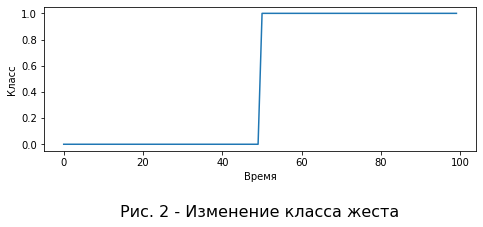

In [15]:
m.get_gest_plot(10, plot_counter=2)

На рис.2 изображена диаграмма изменения класса сигнала. В районе 50 временного промежутка видно изменение класса жеста. Сравнивая её с диаграммой сигналов датчиков (рис.1) мы видим, что на первой реакция датчиков происходит с запаздыванием (примерно на 70 временном интервале).



In [16]:
m.get_active_passive_sensors_plot(10, plot_counter = 3)
m.get_sensor_list(10, print_active=True)
print()

Активные датчики наблюдения 10:  [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Пассивные датчики наблюдения 10: [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39]



На Рис.3 слева представлены показания активных датчиков наблюдения 10, а справа - пассивных датчиков. Рассматривая динамику показаний активных датчиков во времени условно отметим 3 периода:

* 0 - 59 с. - "покой" и слабое изменение;
* 60 - 79 с. - "значительное изменение уровня" сигнала при выполнении жесте;
* 80 - 99 с. - "стабилизаця" после движения. 

Показания пассивных датчиков колеблются с низкой амплитудой по сравнению с амплитудой колебания активных датчиков. Изучим амплитуды сигналов.

### Амплитуды сигналов датчиков

In [17]:
m.get_amplitude(10, plot_counter = 4)

Разделим датчики  по величине амплитуды на 2 группы: 

| Абсолютная <br> амплитуда | группа датчиков |
| :--: | :-- |
| < 200 | слабые |
| > 200 | сильные |

Затем отобразим индексы датчиков на графике

In [18]:
m.get_strong_weak_sensors_plot(10, plot_counter = 5)

 
Датчики с большой амплитудой, наблюдение 10:  [0, 2, 5, 8, 12, 15, 17, 19, 24, 27, 29, 30]
Датчики с малой амплитудой, наблюдение 10:  [21, 33, 36, 38]


На рис. 5 слева сигналы "сильные" датчиков, справа - "слабые". Отметим характерный скачок амплитуды у сильных датчиков в районе 70 временного интервала и практически плавное изменение амплитуды у слабых датчиков. Индексы датчиков по группам:
* сильные: [0, 2, 5, 8, 12, 15, 17, 19, 24, 27, 29, 30]
* слабые:  [21, 33, 36, 38]

Анализируя график можно сказать, что датчики реагируют на движение с небольшим  запаздыванием и разной амплитудой. 

Проверим как реагируют сенсоры в рамках произвольно выбранного жеста.

Выберем жест "0-1" и сравним сигналы 2 сильных датчиков и 2 слабых.

In [18]:
m.get_sensors_in_all_tests_plot('0-1', [24, 27, 33, 36], plot_counter=6)

Наблюдения жеста 0-1: [10, 28, 46, 64, 82, 100, 118, 136, 154, 172, 190, 208, 226, 244, 262, 280, 298, 316]


На рис.6 предствлены показания "сильных" датчиков 24,27 и "слабых" 33,36.
Отметим, что сигнал датчиков изменяется c разной амплитудой и запаздыванием во всех наблюдениях. 



Для фиксации момента начала роста сигнала датчиков рассмотрим поведение первой производной (np.diff c n=1).

In [ ]:
# Анализируем датчик 8 для рассматриваемого наблюдения 2
plot_counter=7
id = 2
time_stp = 0 # начальный интервал времени можно сдвинуть
sensor = 24
df = pd.DataFrame(data = X_train[id], index = [s for s in range(X_train.shape[1])], 
                  columns = [s for s in range(X_train.shape[2])]
).T

y_k = y_train[id*100:(id+1)*100].reset_index().T
# временной промежуток
time_stp = 0
time_end = 100

df_T_50 = df.iloc[time_stp:]
y_k_50 = y_k[range(time_stp, 100)]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle(f'Рис. {plot_counter}'+' - сравнение и преобразование сигнала датчика', y=-0.01, fontsize=16)

ax1.plot(list(df_T_50.index), df_T_50[sensor].values)
ax1.set_title(f'Сигнал датчика {sensor} в наблюдении {id}', fontsize=16)
ax1.set_ylabel('Сигнал датчика')

ax2.plot(list(y_k_50.columns), y_k_50.loc['class'].values)
ax2.set_title(f'Изменение класса жеста', fontsize=16)
ax2.set_ylabel('Класс жеста')

ax3.plot(list(range(len(np.diff(df_T_50[sensor], 3)))), np.diff(df_T_50[sensor],3))
ax3.set_title(f'Производная сигнала датчика {sensor}', fontsize=16)


plt.show()

На рис.7 видно, что уровень сигнала датчика на временном интервале от 0 до 50 падает, хотя на данном промежутке времени жест зафиксирован. Такое поведение датчиков встречается во многих наблюдениях, что добавляет шум к временной зависимости первой производной и момент роста сигнала датчиков при выполнении жеста можно пропустить либо зафиксировать позже (при выставлении большого порога фиксации первой производной). Было решено искать другие возможности фиксации роста уровней сигналов датчиков.  

Следующей идеей была попытка зафиксировать рост уровня сигналов датчиков с помощью скользящих средних с разными таймфреймами. Две скользящие средние с разными таймфреймами в момент роста сигнала будут пересекаться, можно зафиксировать и интерпретировать, как начало выполнения жеста (Аналог MACD-индикатор в финансовом техническом анализе).  